# Semi-Supervised Learning (SSL)


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels

In [119]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 10.

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 12

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'rw'

# Coefficients for C matrix for soft HFS
params['c_l'] = 1.
params['c_u'] = 0.001

In [79]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    ###########TOOD

    # Build one hot encoded vectors
    y = np.zeros((num_samples, num_classes), int)
    for i in range(num_samples):
        if (Y[i] != 0):
            y[i, int(Y[i]- 1)] = 1
    
    indexes = np.arange(0, Y.shape[0])
    l_idx = indexes[Y > 0]
    u_idx= indexes[Y == 0]

    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx] 
        f_u = -np.linalg.inv(L[u_idx][:, u_idx])@(L[u_idx][:, l_idx]@f_l)

        f = np.zeros(y.shape)
        f[l_idx] = f_l
        f[u_idx] = f_u

    else:
        """
        Compute soft HFS.

        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        
        diag = params["c_l"]*np.ones(Y.shape[0])
        diag[u_idx] = params["c_u"]
        C = np.diag(diag)
        
        f = np.linalg.inv(np.linalg.inv(C)@L + np.eye(Y.shape[0]))@y
        
    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """
    labels = np.argmax(f,axis = 1) + 1
    return labels, f


In [80]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """

    
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    
    L = build_laplacian_regularized(X, params['laplacian_regularization'], params['var'], params['eps'], params['k'], params['laplacian_normalization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

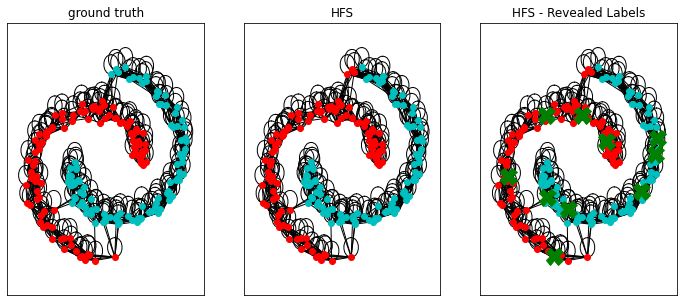

Soft=True, Accuracy=0.985


In [120]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=True, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)
                                                 

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

In [107]:
np.random.seed(42)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, **params)
    
# mask_labels?  # check parameters

AssertionError: only one class in training data!

When using only 4 labelled examples, there is a risk to get 4 examples from one class only. <br>
The error above indeed indicates that there is `only one class in training data!`

### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

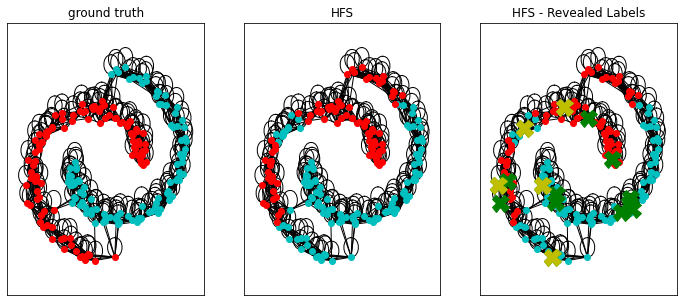

Soft=False, Accuracy=0.78


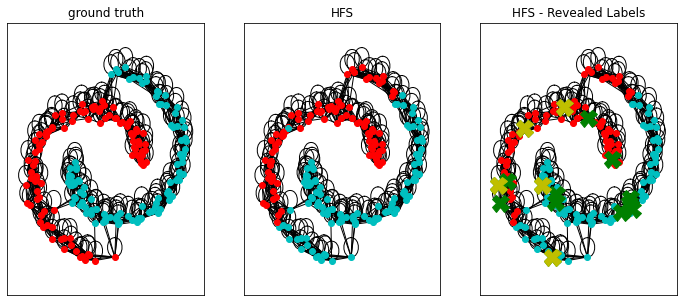

Soft=True, Accuracy=0.84


In [121]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

When running hard and soft HFS with the same paramters, and $c_l = 0.9$ and $c_U = 0.001$, I get respectively .78 and .84 accuracies. In general, when changing the seed, the results are also better with soft HFS, that gives more or less importance to unlabelled images, epending on the values $c_l$ and $c_U$

## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

In order to encode more than two classes in the vector $f_S$, we can use one-hot encoding. For each labelled example of label $c$, the $c^{th}$ component of the one hot encoded vector is equal to 1, the rest is equal to 0. We thus get a $\mathbb{R}^{n\times K} with $K$ the number of classes. In our case, we ommit the class $0$, as it indicates a non-labelled example.  



### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

I get accuracies of 0.83 and 0.58 for the small and augmented datasets respectively.
It is worth noticing that for the small datasets, we had 4 labelled examples per class of 10 examples (0.4 ratio), whereas on the big dataset, we had still 4 labelled examples, but per class of 50 examples (0.08 ratio).
As a result, for the augmented datasest has a lot more variations, and with a large Laplacian matrix, we get less robust results on average.


In [122]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [123]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = .5
params_face_rec['var'] = 150
params_face_rec['eps'] = None
params_face_rec['k'] = 25
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = .90
params_face_rec['c_u'] = .03

In [124]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!
    image = cv2.bilateralFilter(image, 9, 75, 75)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    im -= im.mean()
    im /= im.max()
    image = im
    return image

/tmp/ipykernel_8744/594677276.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


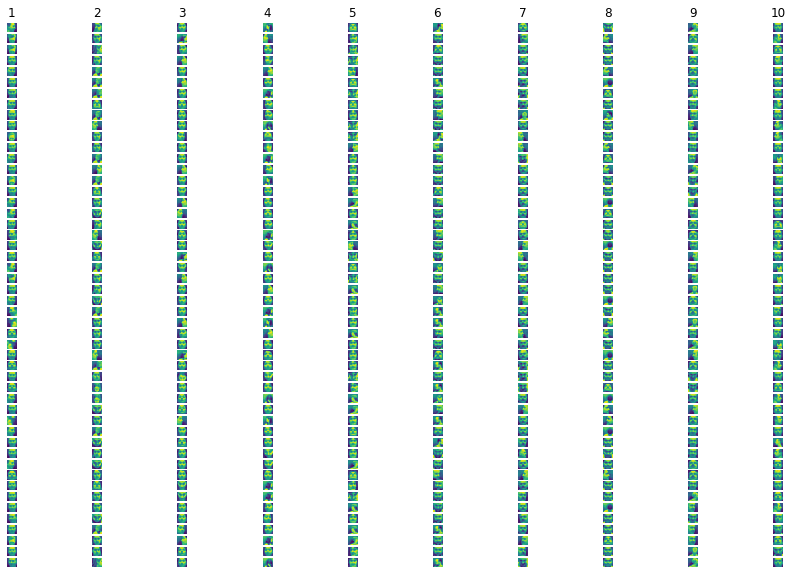

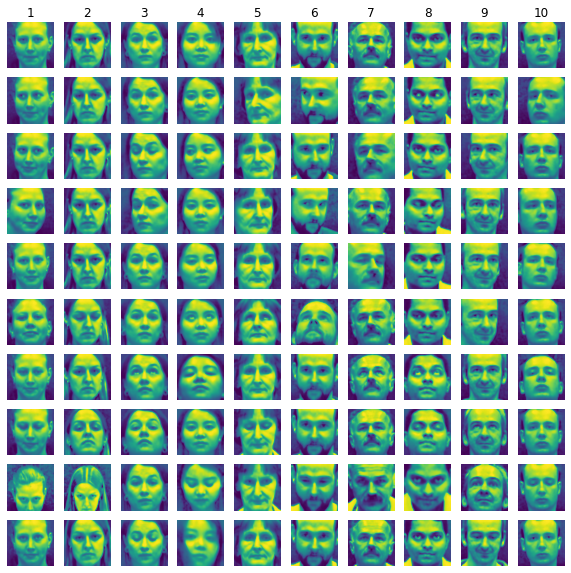

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [125]:
# # 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# 50 images per person
images_a, labels_a, masked_labels_a = load_image_data_augmented(preprocess_image)
plot_image_data_augmented(images_a)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

In [128]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.83


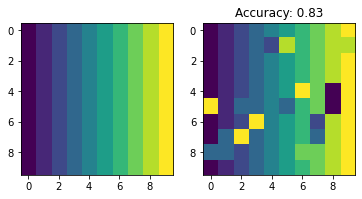

In [130]:
# Run HFS
predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

Augmented dataset results

In [131]:
# graph Laplacian
L_a = build_laplacian_regularized(images_a, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

Accuracy =  0.618


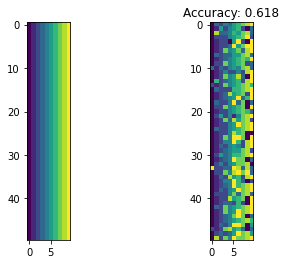

In [132]:
# Run HFS
predicted_labels, f = compute_hfs(L_a, masked_labels_a, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels_a).mean()
print("Accuracy = ", accuracy)

# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels_a.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

On known faces, the online SSL works pretty well in similar conditions of lightning as the labelled images, but gets worse as soon as the conditions change.
This might also be due to the preprocessing on the images which is too simple here, and doesn't account for color/luminosity/contrast changes.



![title](results/me.png)
![title](results/two_faces.png)






### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.



In order to label a face as unknown, my strategy was to try to measure how uncertain the prediction was. 
To do this, I tried some classic confidence measures, and label a face as unknown when the measure was below a certain threshold.
Using the entropy or variance of the scores vector components, I did not manage to get clear variations when using unknown faces.
In the end, I compared $max(scores)$ to a threshold (I used $threshold=0.2$) to define a face as unknown.

![title](results/ak.png)


In [92]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
from scipy.special import softmax
from scipy.stats import entropy

import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition

In [93]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = .1
params_online_ssl['var'] = 10000
params_online_ssl['eps'] = None
params_online_ssl['k'] = 4
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 1.
params_online_ssl['c_u'] = .02

In [94]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):

        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)
                ), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels

        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """

        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(
            self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces,
                                 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(
            range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.

        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample

        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)
                ), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init =  False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """

            (c1, c2) = np.unravel_index(
                np.argmin(self.centroids_distances), self.centroids_distances.shape)
            # c_rep, c_add = None, None

            if self.taboo[c1]:
                c_rep, c_add = c1, c2
            elif self.taboo[c2]:
                c_rep, c_add = c2, c1
            elif self.V[c2] <= self.V[c1]:
                c_rep, c_add = c1, c2
            else:
                c_rep, c_add = c2, c1

            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] += self.V[c_add]
            self.centroids[c_add] = face
            self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(
                np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)

        # Build quantized graph and its regularized Laplacian
        W = build_similarity_graph(
            self.centroids, var=params_online_ssl["var"], eps=params_online_ssl["eps"], k=params_online_ssl["k"])
        L = build_laplacian(V @ W @ V)
        Q = L + params_online_ssl["laplacian_regularization"]*np.eye(L.shape[0])  # regularized Laplacian

        # Compute the hard HFS solution f.
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))

        # handle unknown faces
        # scores = softmax([x[1] for x in label_scores])
        scores = [x[1] for x in label_scores]
        ent = entropy(scores, base = 2)
        if np.max(scores) < .2:
            label_scores.append(("unknown", 10000.))
        
        return label_scores


In [103]:
# create_user_profile('pez')         # choose your names here :)
# create_user_profile('arthur')
# create_user_profile('yoach')
online_face_recognition(['pez', 'arthur', "yoach"], IncrementalKCenters, n_pictures=7)
clear_output()

### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification


The objective is to try to detect several occurences of the same face in order to make a labelled centroid out of them when seen enough time.

During online update, when a new centroid appears, two previous centroids are merged and their multiplicities added. 
Thus we can use a similar multiplicity as an indicator of how many times a face has been seen. I did not use the original multiplicities $V$ values because they did not contain information of wether or not the face was unknown.

Thus I proceed as follows:
* During initialization, a list of unkown faces multiplicities (`unknown_V`) is initialized (at values 0)   
* When a new face appears:
	* if it is unknown, we set its *unknow multiplicity* to 1
	* otherwise it is set to 0
* When two centroids are merged, we also merge (add) their *unknown multiplicities*.
* Every centroid that is not labelled, and with an *unknown multiplicity* above the threshold is labelled as a new class, with an associated name.


Below is the adapted class, (recopied for more clarity ith previous questions)

The relevant modifications are at lines **40**, **63** and **188** of the below code.



In [133]:
class IncrementalKCenters_auto_label:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):

        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)
                ), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels

        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None

        # Init unknonw multiplicity list, threshold, automatic names.
        self.unknown_count_threshold = 15
        self.unknown_V = None
        self.random_names = ["joe", "pierre", "marco", "martin", "bozo", "james"]

    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """

        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(
            self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces,
                                 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(
            range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize unknown multiplicities
        self.V = np.ones(self.centroids.shape[0])
        self.unknown_V = np.zeros(self.centroids.shape[0])

    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.

        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample

        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)
                ), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init =  False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """

            (c1, c2) = np.unravel_index(
                np.argmin(self.centroids_distances), self.centroids_distances.shape)
            # c_rep, c_add = None, None

            if self.taboo[c1]:
                c_rep, c_add = c1, c2
            elif self.taboo[c2]:
                c_rep, c_add = c2, c1
            elif self.V[c2] <= self.V[c1]:
                c_rep, c_add = c1, c2
            else:
                c_rep, c_add = c2, c1

            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] += self.V[c_add]
            self.centroids[c_add] = face
            self.V[c_add] = 1


            # Add unknown counts of merged centroids and set to zero for the new centroid
            self.unknown_V[c_rep] += self.unknown_V[c_add]
            self.unknown_V[c_add] = 0

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(
                np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)

        # Build quantized graph and its regularized Laplacian
        W = build_similarity_graph(
            self.centroids, var=params_online_ssl["var"], eps=params_online_ssl["eps"], k=params_online_ssl["k"])
        L = build_laplacian(V @ W @ V)
        Q = L + params_online_ssl["laplacian_regularization"]*np.eye(L.shape[0])  # regularized Laplacian

        # Compute the hard HFS solution f.
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y))-1
        label_scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))

        # handle unknown faces
        # scores = softmax([x[1] for x in label_scores])
        # ent = entropy(scores, base = 2)
        # var = np.var(scores)
        scores = [x[1] for x in label_scores]

        # unknown face detection
        if np.max(scores) < .2:
            label_scores.append(("unknown", 10000.))

            # Keep track of unknown faces
            if self.V is not None:
                # if maximum number of centroids have been reached:
    
                # Set unknown multiplicity to one for given new centroid
                self.unknown_V[self.last_face] += 1

                # Create new label for every unlabled centroid with unknown multiplicity above the threshold
                for i in np.argwhere((self.unknown_V >= self.unknown_count_threshold) & (self.Y == 0)):
                    # New label
                    self.taboo[i] = 1
                    self.label_names.append("auto." + self.random_names[0])
                    self.random_names =  self.random_names[1:]
                    self.random_names.append(self.random_names[np.random.randint(0, len(self.random_names))]+"-"+self.random_names[0])
                    self.unknown_V[i] = 0
                    self.Y[i] = len(self.label_names) 
                    print("Created new user:", self.label_names[-1])

        return label_scores


In [134]:
from IPython.display import clear_output


In [136]:
online_face_recognition(['pez', 'arthur', "yoach"], IncrementalKCenters_auto_label, n_pictures=7)
# clear output (too much opencv error mesages)
clear_output()

Below is the new online SSL with a freshly created user **auto.joe** (threshold of 15 was used to auto label)

![title](results/auto.joe.png)


    
### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:
* Supervised vs Semi-supervised
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.
* Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

**Supervised vs Semi-supervised**

I decided to test Supervised vs Unsupervised.

I started from the augmented image dataset.
I incrementally augmented the number of unlabelled image per cass (from 1 to 49). For each value, I averaged the accuracy of random forest classifiers vs HFS.
The test was done on the unlabelled images each time.

However: it is obvious that evaluating on the unlabelled images becomes more and more erroneous as the number of unlabelled images gets lower and lower. (for instance at the end, we evaluate on 1 unlabelled image per class).

In any case, I have displayed the scores of supervised vs unsupervised for each proportion of laelled images.
The last cell shows that there is no clear difference in performance, and he accuracies plots are pretty similar.

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = .5
params_face_rec['var'] = 150
params_face_rec['eps'] = None
params_face_rec['k'] = 25
params_face_rec['laplacian_normalization'] = 'unn'
params_face_rec['c_l'] = .90
params_face_rec['c_u'] = .03

In [55]:
images, labels, _ = load_image_data_augmented(preprocess_image)


/tmp/ipykernel_8744/594677276.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


In [68]:
images.shape
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,
        2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,
        6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,
        3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9,
       10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,
        7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,
        4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
        1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,
        5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,
        2,  3,  4,  5,  6

In [56]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

In [74]:
# Compare semi sueprvised an supervised

N_per_class = 50
sub_iter = 5

accuracies_hfs = []
accuracies_forest = []

# For each numver of masked elemens per class
for i in range (1, N_per_class):
    accuracies_hfs.append(0)
    accuracies_forest.append(0)

    # Run training several times and average
    for _ in range(sub_iter):
        np.random.seed()
        masked_labels = mask_labels(labels, i, per_class= True)

        # HFS
        predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
        # accuracy_ss = np.equal(predicted_labels, labels).mean()
        accuracy_ss = np.equal(predicted_labels[masked_labels == 0], labels[masked_labels == 0]).mean()

        # Random forest
        images_train = images[masked_labels != 0]
        labels_train = labels[masked_labels != 0]
        forest_clf= RandomForestClassifier(n_estimators=200)
        forest_clf.fit(images_train, labels_train)
        predicted_supervised = forest_clf.predict(images)
        accuracy_supervised = np.equal(predicted_supervised[masked_labels == 0], labels[masked_labels == 0]).mean()

        # Add current accuracy
        accuracies_hfs[-1] += accuracy_ss
        accuracies_forest[-1] += accuracy_supervised

    # Average accuracies
    accuracies_hfs[-1] /= sub_iter
    accuracies_forest[-1] /= sub_iter

    print("Labels per class:", str(i) + "/" + str(N_per_class))
    print("Accuracy random forest = ", accuracies_forest[-1])
    print("Accuracy hfs = ", accuracies_hfs[-1])
    print()

Labels per class: 1/50
Accuracy random forest =  0.2714285714285714
Accuracy hfs =  0.20816326530612245

Labels per class: 2/50
Accuracy random forest =  0.36041666666666666
Accuracy hfs =  0.3625

Labels per class: 3/50
Accuracy random forest =  0.5531914893617021
Accuracy hfs =  0.448936170212766

Labels per class: 4/50
Accuracy random forest =  0.5695652173913044
Accuracy hfs =  0.4826086956521739

Labels per class: 5/50
Accuracy random forest =  0.6377777777777778
Accuracy hfs =  0.5755555555555556

Labels per class: 6/50
Accuracy random forest =  0.675
Accuracy hfs =  0.6022727272727273

Labels per class: 7/50
Accuracy random forest =  0.7441860465116279
Accuracy hfs =  0.6511627906976745

Labels per class: 8/50
Accuracy random forest =  0.7476190476190476
Accuracy hfs =  0.6785714285714286

Labels per class: 9/50
Accuracy random forest =  0.7780487804878049
Accuracy hfs =  0.7195121951219512

Labels per class: 10/50
Accuracy random forest =  0.785
Accuracy hfs =  0.76

Labels per

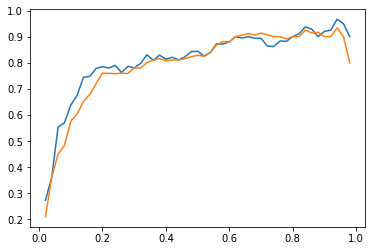

In [76]:
plt.plot(np.arange(1,50)/50, accuracies_forest)
plt.plot(np.arange(1,50)/50, accuracies_hfs)

**x-axis** proportion of unlabelled examples <br>
**blue y-axis** accuracy of random forest classifier <br>
**orange y-axis** accuracy of HFS classifier <br>
